### Launches as API call to USDA, then plots data.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

In [4]:
def crop_rating(year_param, unit_desc_param):

    ploads = {'format': 'JSON',
              'or_desc': 'CROPS',
              'domain_desc': 'TOTAL',
              'agg_level': 'STATE',
              'state_name': 'IOWA',
              'year__GE': year_param,
              'commodity_desc': 'CORN',
              'unit_desc': unit_desc_param,
              'statisticcat_desc': 'CONDITION'
              }
    # key (make a parameter)
    r = requests.get("https://quickstats.nass.usda.gov/api/api_GET/?key=1C757E50-5169-30CC-BEFD-40A5C3E2A43D", params=ploads)
    # execute get request
    dt1 = json.dumps(r.json(), indent=2, sort_keys=True)
    # make it json format
    obj1 = json.loads(dt1)

    # collect relevant data for each object created
    dt2 = []
    for i in obj1["data"]:
        dt2.append([i["year"], i["reference_period_desc"], i["commodity_desc"], i["Value"], i['unit_desc']])
    # convert from dictionary format to pandas
    dt3 = pd.DataFrame.from_dict(dt2)
    return dt3

In [12]:
# need to sum pct good and excellent
desc1 = ['PCT EXCELLENT', 'PCT GOOD']

# create separate lists for each description (good, excellent)
df100 = []
for desc in desc1:
    df100.append(crop_rating(2008, desc))
        
# combine dataframes
df10 = pd.concat(df100)
df10.columns = ["year", "week", "crop", "percent", "quality"]
df10["percent"] = df10["percent"].astype(int)     
df10.head(500)

,year,week,crop,percent,quality
0,2020,WEEK #21,CORN,14,PCT EXCELLENT
1,2020,WEEK #22,CORN,14,PCT EXCELLENT
2,2020,WEEK #23,CORN,15,PCT EXCELLENT
3,2020,WEEK #24,CORN,15,PCT EXCELLENT
4,2020,WEEK #25,CORN,16,PCT EXCELLENT
...,...,...,...,...,...
217,2010,WEEK #28,CORN,48,PCT GOOD
218,2010,WEEK #29,CORN,43,PCT GOOD
219,2010,WEEK #30,CORN,43,PCT GOOD
220,2010,WEEK #31,CORN,45,PCT GOOD


In [13]:
# sum excellent and pct good
df11 = df10.groupby(['year', 'week', 'crop']).agg({'percent': 'sum'}).reset_index()
df11.head(5)

,year,week,crop,percent
0,2008,WEEK #22,CORN,66
1,2008,WEEK #23,CORN,56
2,2008,WEEK #24,CORN,49
3,2008,WEEK #25,CORN,50
4,2008,WEEK #26,CORN,53


In [14]:
# clean up columns to create date object
df11['weekofyear'] = df11['week'].map(lambda x: x.lstrip('WEEK #'))
# # year is an int, so it week, make year 1990 to 199000 and add week of year so 199032 (32 week)
df11["yearweek"]  = df11.year.astype(int) * 100 + df11.weekofyear.astype(int)
df11.head(10)

,year,week,crop,percent,weekofyear,yearweek
0,2008,WEEK #22,CORN,66,22,200822
1,2008,WEEK #23,CORN,56,23,200823
2,2008,WEEK #24,CORN,49,24,200824
3,2008,WEEK #25,CORN,50,25,200825
4,2008,WEEK #26,CORN,53,26,200826
5,2008,WEEK #27,CORN,57,27,200827
6,2008,WEEK #28,CORN,58,28,200828
7,2008,WEEK #29,CORN,62,29,200829
8,2008,WEEK #30,CORN,59,30,200830
9,2008,WEEK #31,CORN,64,31,200831


In [15]:
# format to datetime
df11['date'] = pd.to_datetime(df11.yearweek.astype(str) + '0', format='%Y%W%w')
# set date as index
df12 = df11.set_index("date")
# drop unnecessary columns
df12 = df12.drop(["week","weekofyear", "yearweek"], axis = 1)
df12.head(10)

,year,crop,percent
date,,,
2008-06-08,2008,CORN,66
2008-06-15,2008,CORN,56
2008-06-22,2008,CORN,49
2008-06-29,2008,CORN,50
2008-07-06,2008,CORN,53
2008-07-13,2008,CORN,57
2008-07-20,2008,CORN,58
2008-07-27,2008,CORN,62
2008-08-03,2008,CORN,59


In [16]:
# create week and year columns for plotting purposes only
df12['week'] = pd.to_datetime(df12.index).week.astype(int)
df12['year'] = pd.to_datetime(df12.index).year.astype(int)
df12.head(10)

,year,crop,percent,week
date,,,,
2008-06-08,2008,CORN,66,23
2008-06-15,2008,CORN,56,24
2008-06-22,2008,CORN,49,25
2008-06-29,2008,CORN,50,26
2008-07-06,2008,CORN,53,27
2008-07-13,2008,CORN,57,28
2008-07-20,2008,CORN,58,29
2008-07-27,2008,CORN,62,30
2008-08-03,2008,CORN,59,31


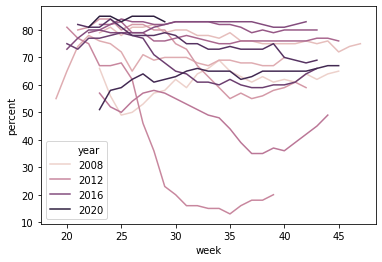

In [17]:
df12.to_csv("data/cropCorn.csv")
# plot week for each year, put in one figure
sns.lineplot(x='week',y='percent',hue='year',data=df12)
plt.show()